In [1]:
import numpy as np

In [43]:
from matplotlib import pyplot as plt

Problema: Tiramos dardos a un blanco de radio 1 y queremos saber la distribución de radios si los dardos caen en lugares aleatorios

In [66]:
v = np.random.uniform(-1, 1, [20000, 2])

In [67]:
r = np.sqrt(v[:,0]**2 + v[:,1]**2)

In [68]:
vc = v[r<1,:]

In [69]:
rc = r[r<1]

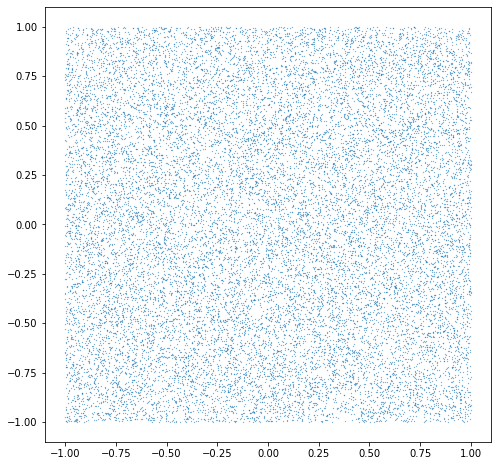

In [70]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(v[:,0], v[:,1], linestyle='None', marker='.', markersize=0.5)

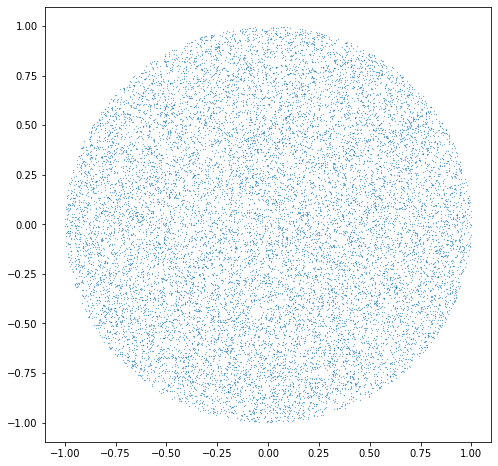

In [71]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(vc[:,0], vc[:,1], linestyle='None', marker='.', markersize=0.5)

Text(0, 0.5, '1/N dN/dr')

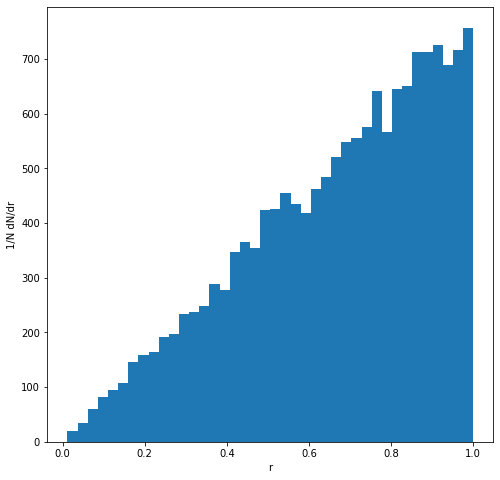

In [127]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.hist(rc, bins=40)
ax.set_xlabel('r')
ax.set_ylabel('1/N dN/dr')

$\rule{0pt}{30pt}$
_________

**Una lluvia de meteoritos se produce cuando la Tierra pasa por una región con restos de un cometa.  El ápex se encuentra en las coordenadas:**

$$(\alpha, \delta)=(30, -4)$$

**¿Cuál es la probabilidad de observar meteoritos desde Bosque Alegre, a las 5 de madrugada, a una distancia cenital menor de 30 grados?**

Hagamos una simulación

Este es el plan: 

1. Calcular las posiciones en una esfera suponiendo que el apex está en el eje Z.
2. Calcular la posición relativa entre el apex y el cenit
3. Calcular las distancias entre el cenit y las posiciones aleatorias
4. Calcular la fracción que es menor que 30$^o$

In [381]:
alpha = 30
delta = -4
dist_cen_max = 30
hora = 5

In [535]:
from astropy.coordinates import EarthLocation
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import AltAz
from astropy.coordinates import SkyCoord

### Transformación entre sistemas de coordenadas

In [570]:
EABA = EarthLocation(lat='-31d', lon='-64d', height=1300*u.m)
observing_time = Time(f'2020-08-27 {hora+3}:00')   # hora en UTC
aa = AltAz(location=EABA, obstime=observing_time)

In [571]:
aa

<AltAz Frame (obstime=2020-08-27 08:00:00.000, location=(2399251.52441657, -4919194.61742628, -3266563.06615133) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)>

In [572]:
apex_eq = SkyCoord(alpha*u.deg, delta*u.deg, frame='icrs')

In [573]:
apex_eq

<SkyCoord (ICRS): (ra, dec) in deg
    (30., -4.)>

In [574]:
apex_aa = apex_eq.transform_to(aa)

In [575]:
apex_aa

<SkyCoord (AltAz: obstime=2020-08-27 08:00:00.000, location=(2399251.52441657, -4919194.61742628, -3266563.06615133) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (356.15941663, 62.8493083)>

In [576]:
apex_aa.cartesian

<CartesianRepresentation (x, y, z) [dimensionless]
    (0.45530754, -0.03056543, 0.88980942)>

El coseno del ángulo se puede obtener con el producto punto de los dos vectores, o sea:

In [577]:
cos_sep = apex_aa.cartesian.z

In [578]:
cos_sep

<Quantity 0.88980942>

In [579]:
sep = np.arccos(cos_sep)

In [580]:
print(f'La separación entre el cenit y el apex es {sep.value: .3f} {sep.unit} ')

La separación entre el cenit y el apex es  0.474 rad 


In [581]:
sep_deg = sep.to(u.deg)

In [592]:
print(f'La separación entre el cenit y el apex es {sep_deg.value: .3f} {sep_deg.unit} ')

La separación entre el cenit y el apex es  27.151 deg 


### Simulación

In [594]:
N = 2000
xx, yy = np.random.uniform(-1, 1, size=(2, N))
zz = np.random.uniform(0, 1, size=N)

X =    np.column_stack([xx, yy, zz])
norma = np.linalg.norm(X, axis=1)

esfera = norma<1

x = xx[esfera]
y = yy[esfera]
z = zz[esfera]
N = len(x)

Ahora, para cada punto que generamos random, calculamos la distancia al cenit.

En el sistema que apunta al apex, las coordenadas del cenit son:

In [595]:
cenit = np.array([0, np.sqrt(1-cos_sep**2), cos_sep])

In [596]:
cenit

array([0.        , 0.45633233, 0.88980942])

In [597]:
angdist = []
for i in range(len(x)):
    d = np.dot(cenit, [x[i], y[i], z[i]])
    theta = np.arccos(d)
    angdist.append(theta)

In [598]:
angdist = np.array(angdist)*180./np.pi
near = angdist<dist_cen_max
angdist.sort()

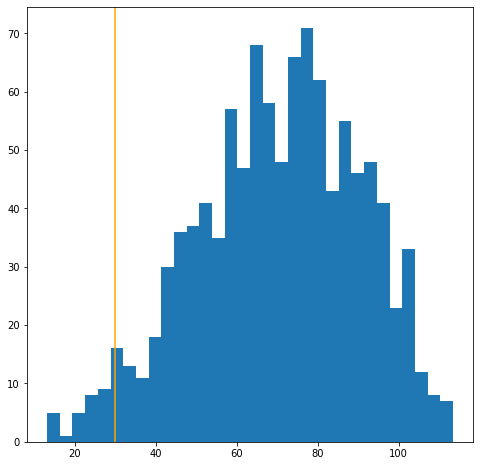

In [604]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.hist(angdist, bins=int(np.sqrt(N)))
ax.axvline(dist_cen_max, color='orange')

In [605]:
proba = sum(angdist<30)/N
print(f'\nLa probabilidad de que un meteorito se vea a una\ndistancia cenital menor que 30 grados es {proba}\n')


La probabilidad de que un meteorito se vea a una
distancia cenital menor que 30 grados es 0.03497164461247637



Text(0, 0.5, 'F')

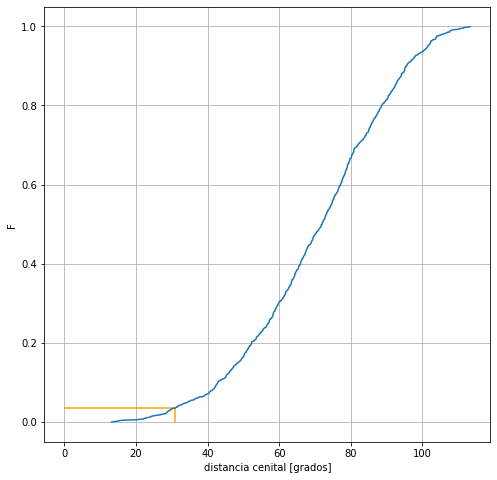

In [606]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
plt.plot(angdist, np.array(range(N))/N)
i = np.argmin(angdist<30)
ax.vlines(x=angdist[i], ymin=0, ymax=proba, linestyle='-', color='orange')
ax.hlines(y=proba, xmin=0, xmax=angdist[i], linestyle='-', color='orange')
ax.grid()
ax.set_xlabel('distancia cenital [grados]')
ax.set_ylabel('F')

Text(0, 0.5, 'Y')

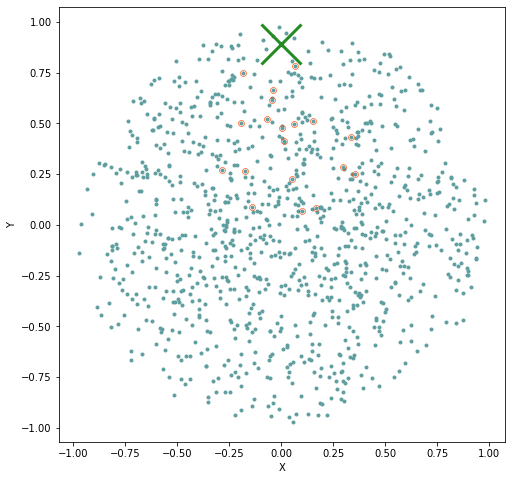

In [590]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(x, y, marker='.', linestyle='None', color='cadetblue')
ax.plot(x[near], y[near], marker='o', markersize=6, mew=0.6 ,linestyle='None', color='orangered', mfc='None')
ax.plot([0], [cos_sep], marker='x', markersize=40, color='forestgreen', mew=3)
ax.set_xlabel('X')
ax.set_ylabel('Y')